In [117]:
import os
from pathlib import Path


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist



In [36]:
CUR_DIR = os.path.abspath('C:/Users/pierr/Documents/Datascientist/reco-musicale/AVR23_BDS_reco_musicale/notebooks')
# CUR_DIR
DATA_DIR = Path(CUR_DIR).parent / "data"
FILE_PATH = DATA_DIR/'triplets_metadata_spotify.csv'
df = pd.read_csv(FILE_PATH, index_col = 0)

In [37]:
df.head()

,user,listening_count,song_name,release,artist_name,duration,artist_familiarity,artist_hotttnesss,year,shs_perf,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_date
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
1,9fba771d9731561eba47216f6fbfc0023d88641b,19,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
2,85952991b8e3ca5803a08b0b2f9c6d71abf9bb5b,1,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
3,537340ff896dea11328910013cfe759413e1eeb3,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24
4,8fce200f3912e9608e3b1463cdb9c3529aab5c08,2,Stronger,Graduation,Kanye West,311.84934,0.877214,1.082503,2007,-1,...,-7.933,0,0.176,0.00763,0.0,0.526,0.495,103.977,4.0,2011-05-24


In [38]:
len(df)

4982520

## Songs features selection

In [39]:
df.columns

Index(['user', 'listening_count', 'song_name', 'release', 'artist_name',
       'duration', 'artist_familiarity', 'artist_hotttnesss', 'year',
       'shs_perf', 'shs_work', 'explicit', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_date'],
      dtype='object')

In [65]:
tracks_feats = df.drop(['user', 'listening_count'],axis = 1).drop_duplicates()
len(tracks_feats)

27996

In [66]:
artists = tracks_feats.artist_name
songs = tracks_feats.song_name
release = tracks_feats.release

labels = artists + '-' + songs

In [67]:
labels.head()

0                Kanye West-Stronger
18275            Kanye West-Stronger
18315    Foo Fighters-Stacked Actors
20077             John Mayer-Clarity
22871             John Mayer-Clarity
dtype: object

In [83]:
## Quantitative feats only
tracks_quanti_feats = tracks_feats.drop(['song_name', 'release', 'artist_name',
        'artist_familiarity', 'artist_hotttnesss', 'year', 'key',
       'shs_perf', 'shs_work', 'explicit', 'mode', 'time_signature', 'release_date'], axis = 1)

In [84]:
tracks_quanti_feats.columns

Index(['duration', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

## Univariate statistics description

In [86]:

tracks_quanti_feats.describe()

,duration,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000,27996.000000
mean,243.720036,0.511489,0.640862,-8.971855,0.079205,0.273538,0.204387,0.214130,0.481211,121.598569
std,108.921528,0.178937,0.254574,4.434172,0.099125,0.322783,0.328058,0.187802,0.259907,30.055173
min,4.074650,0.000000,0.000020,-44.534000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,184.920360,0.383000,0.456000,-11.183000,0.033775,0.006188,0.000005,0.097400,0.265000,98.110250
50%,230.477910,0.516000,0.682000,-8.050000,0.045100,0.105000,0.001790,0.134000,0.473000,119.864000
75%,281.867300,0.643000,0.862000,-5.859000,0.076900,0.509000,0.330000,0.280000,0.690000,140.010000
max,2999.509750,0.978000,1.000000,3.599000,0.963000,0.996000,0.997000,0.997000,1.000000,231.028000


## Bivariate statistcal analysis

<Axes: >

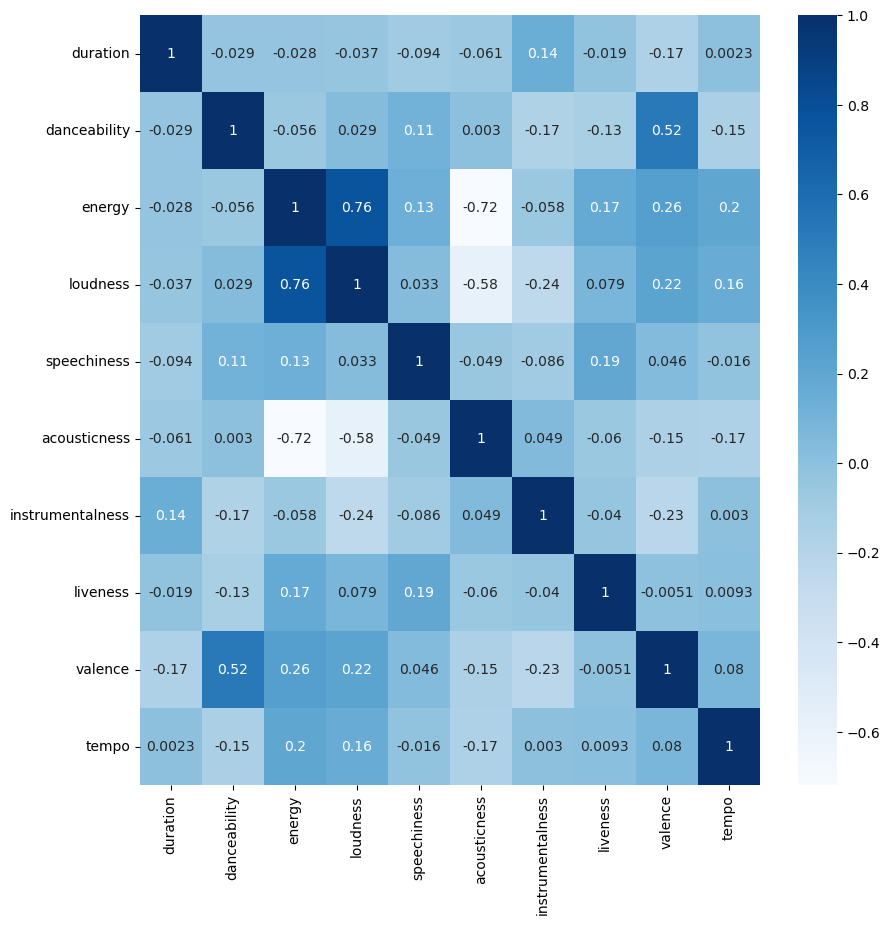

In [99]:
corr = tracks_quanti_feats.corr()
plt.figure(figsize =(10,10))
sns.heatmap(corr, cmap="Blues", annot=True)

There are no clear correlation between the variables, except
- a rather strong positive correlation between energy and loudness,
- a medium positive correlation between valence and danceability
- a rather strong negative correlation between energy and acousticness

## Multivariate quantitative analysis : PCA

In [87]:
scaler = StandardScaler()
scaler.fit(tracks_quanti_feats)
X = scaler.transform(tracks_quanti_feats)

In [88]:

pca = PCA()

reduced = pca.fit_transform(X)

# Append the principle components for each entry to the dataframe
# for i in range(0, n_components):
#     df['PC' + str(i + 1)] = reduced[:, i]

# display(df.head())

# Do a scree plot


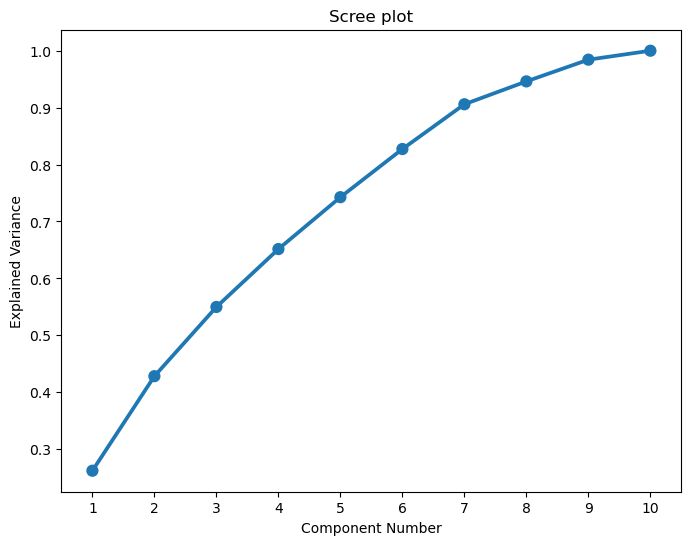

In [92]:
ind = np.arange(0, reduced.shape[1])
(fig, ax) = plt.subplots(figsize=(8, 6))
sns.pointplot(x=ind, y=np.cumsum(pca.explained_variance_ratio_))
ax.set_title('Scree plot')
ax.set_xticks(ind)
ax.set_xticklabels(ind+1)
ax.set_xlabel('Component Number')
ax.set_ylabel('Explained Variance')
plt.show()

There is not a clear elbow on the explained variance.
Almost 7 components are necessary to explain more than 90% of the variance while the original dataset have 10 variables.

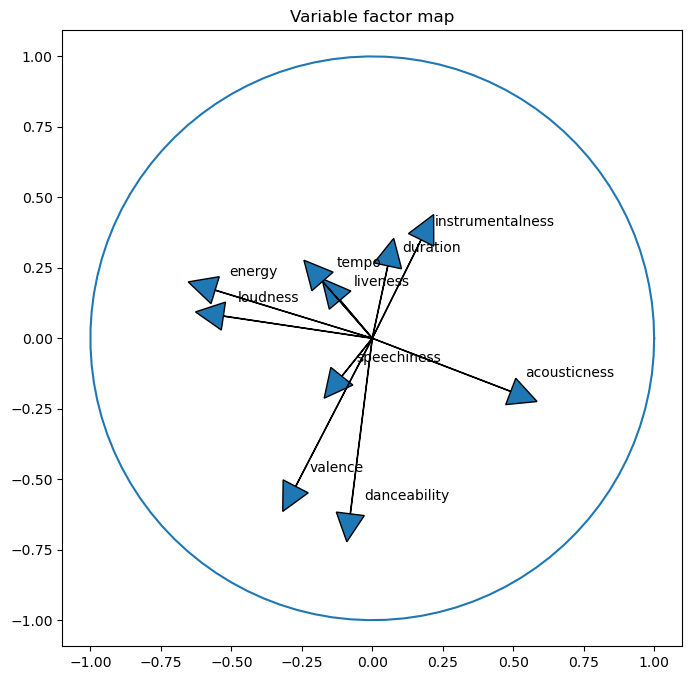

In [90]:
(fig, ax) = plt.subplots(figsize=(8, 8))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             tracks_quanti_feats.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
ax.set_title('Variable factor map')
plt.show()

There is no good correlation between the variables and the first and second component of the ACP.
It is not clear

This short analysis demonstrate that a ACP transformation will not have a clear interest for the dataset.

## Clustering analysis

In [108]:
# Kmeans

distorsions = []

for i in range(100):
#     print(i+2)
    clf = KMeans(n_clusters = i+2, n_init = 'auto')
    clf.fit(X)
    centroids = clf.cluster_centers_
    labels = clf.labels_
    distorsions.append(sum(np.min(cdist(XA = centroids, XB = X), axis = 0)) / len(df))

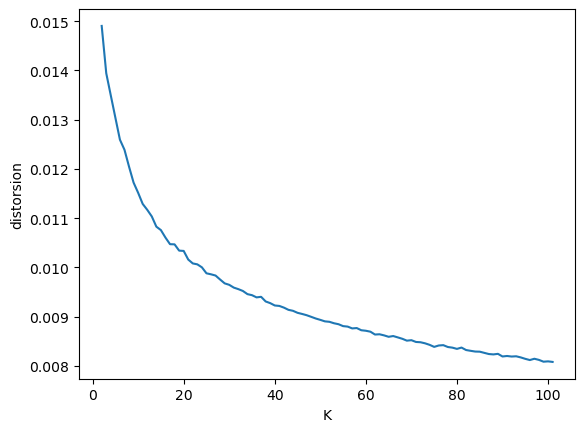

In [112]:
plt.plot([i+2 for i in range(100)], distorsions);
plt.xlabel("K")
plt.ylabel("distorsion");

In [118]:
# Hierarchical Clustering
Z = linkage(X, method = 'ward', metric = 'euclidean')

In [119]:
range_n_clusters = [i+2 for i in range(50)]

s_scores = []
for k in range_n_clusters:
    display(k)
    labels = fcluster(Z, t=k, criterion='maxclust')
    s_scores.append(silhouette_score(X, labels, metric='sqeuclidean'))

2

3

4

5

6

7

8


KeyboardInterrupt



In [ ]:
plt.plot(range_n_clusters, s_scores, '-x');